# This project aims to classify gearbox (either manual or automatic) based on a dataset containing data about cars

**Table of contents**    
- Importing libraries    
- Reading the data    
- Exploring the data    
  - NaN values    
  - Sorting unnecessary columns out    
  - Dropping NaN values from selected columns    
  - Exploring value_counts() for each category    
  - Handling near-zero-variance variables    
  - Get dummy variables    
- Logistic regression    
  - Data partition    
  - First logistic regression model    
  - Classification report for the test set    
  - ROC curve for the test set    
  - Upsampling the train set to make the 0's and 1's evenly frequent    
  - Second model - logistic regression with upsampled train set    
  - Classification report for the test set (based on model fit on the upsampled train set)    
- Random Forest    
  - Classification report for the test set    
  - Classification report for the test set (model fitted on upsampled train set)    
  - Feature importance for the test set (model fitted on upsampled train set)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

## Reading the data

In [2]:
df = pd.read_csv('autos.csv',encoding='latin-1')

## Exploring the data

In [3]:
df.shape

(371528, 20)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

### NaN values

In [5]:
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(f'column: {column}:\nNaN count: {df[column].isna().sum()}\nNaN share: {round(df[column].isna().sum() / df.shape[0],4)}\n')

column: vehicleType:
NaN count: 37869
NaN share: 0.1019

column: gearbox:
NaN count: 20209
NaN share: 0.0544

column: model:
NaN count: 20484
NaN share: 0.0551

column: fuelType:
NaN count: 33386
NaN share: 0.0899

column: notRepairedDamage:
NaN count: 72060
NaN share: 0.194



### Sorting unnecessary columns out

In [6]:
df = df.loc[:,~df.columns.isin(['dateCrawled','dateCreated','lastSeen','model','name','nrOfPictures','postalCode','monthOfRegistration'])]

### Dropping NaN values from selected columns

In [7]:
df =  df.dropna(subset=['vehicleType','gearbox','notRepairedDamage','fuelType'])

### Exploring value_counts() for each category

In [8]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'{column}:\n{df[column].value_counts()}\n')

seller:
privat        268010
gewerblich         2
Name: seller, dtype: int64

offerType:
Angebot    268008
Gesuch          4
Name: offerType, dtype: int64

abtest:
test       139158
control    128854
Name: abtest, dtype: int64

vehicleType:
limousine     78160
kleinwagen    60706
kombi         54451
bus           25501
cabrio        19203
coupe         15334
suv           12675
andere         1982
Name: vehicleType, dtype: int64

gearbox:
manuell      205177
automatik     62835
Name: gearbox, dtype: int64

fuelType:
benzin     174476
diesel      88461
lpg          4184
cng           470
hybrid        242
andere         99
elektro        80
Name: fuelType, dtype: int64

brand:
volkswagen        55213
bmw               30879
mercedes_benz     27264
opel              26959
audi              25122
ford              17777
renault           11922
peugeot            8125
fiat               6511
seat               5096
skoda              4589
mazda              4153
toyota             3757
cit

#### Columns 'seller' and 'offerType' are (almost) zero variance variables and they should be removed

In [9]:
df = df.loc[:,~df.columns.isin(['seller','offerType'])]

#### <br>Searching for near-zero-variance variables. In the example below, total number of rows (df.shape[0]) is divided by the number of each (object) variable's category.</br> <br>A near-zero-variance variable is a variable, which ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20) (according to Max Kuhn, who developed the 'caret' package in R). Thefore, while creating dummy variables, we want to ensure that the 0's are 1's are roughly balanced. To achieve that, it's a good idea to get the low-frequent categories of particular variables and consolidate into "other" category.</br>

In [10]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'{column}:\n{df.shape[0]/df[column].value_counts()}\n')

abtest:
test       1.925955
control    2.079966
Name: abtest, dtype: float64

vehicleType:
limousine       3.429017
kleinwagen      4.414918
kombi           4.922077
bus            10.509862
cabrio         13.956778
coupe          17.478284
suv            21.144931
andere        135.223007
Name: vehicleType, dtype: float64

gearbox:
manuell      1.306248
automatik    4.265330
Name: gearbox, dtype: float64

fuelType:
benzin        1.536097
diesel        3.029719
lpg          64.056405
cng         570.238298
hybrid     1107.487603
andere     2707.191919
elektro    3350.150000
Name: fuelType, dtype: float64

brand:
volkswagen           4.854147
bmw                  8.679426
mercedes_benz        9.830252
opel                 9.941467
audi                10.668418
ford                15.076335
renault             22.480456
peugeot             32.986092
fiat                41.162955
seat                52.592622
skoda               58.403138
mazda               64.534553
toyota              

### Handling near-zero-variance variables

In [11]:
df['vehicleType'].replace({'andere':'other'},inplace=True)
df['vehicleType'].replace({'suv':'other'},inplace=True)

In [12]:
df['vehicleType'].value_counts()

limousine     78160
kleinwagen    60706
kombi         54451
bus           25501
cabrio        19203
coupe         15334
other         14657
Name: vehicleType, dtype: int64

In [13]:
df['fuelType'].replace({'lpg':'other',
                        'cng':'other',
                        'hybrid':'other',
                        'andere':'other',
                        'elektro':'other'},inplace=True)

In [14]:
df['fuelType'].value_counts()

benzin    174476
diesel     88461
other       5075
Name: fuelType, dtype: int64

In [15]:
def fix_brand(x):
    if x in ['volvo','sonstige_autos','mitsubishi','kia','honda',
    'porsche','alfa_romeo','suzuki','chevrolet','chrysler',
    'dacia','land_rover','jeep','subaru','daihatsu','jaguar',
    'saab','daewoo','lancia','rover','trabant','lada','hyundai',
    'mini','smart','nissan','citroen','toyota','mazda','skoda','seat','fiat']:
        return 'other'
    else:
        return x    

In [16]:
df['brand'] = df['brand'].apply(fix_brand)

#### Now the categories frequency are fixed

In [17]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'{column}:\n{df.shape[0]/df[column].value_counts()}\n')

abtest:
test       1.925955
control    2.079966
Name: abtest, dtype: float64

vehicleType:
limousine      3.429017
kleinwagen     4.414918
kombi          4.922077
bus           10.509862
cabrio        13.956778
coupe         17.478284
other         18.285597
Name: vehicleType, dtype: float64

gearbox:
manuell      1.306248
automatik    4.265330
Name: gearbox, dtype: float64

fuelType:
benzin     1.536097
diesel     3.029719
other     52.810246
Name: fuelType, dtype: float64

brand:
other             4.139118
volkswagen        4.854147
bmw               8.679426
mercedes_benz     9.830252
opel              9.941467
audi             10.668418
ford             15.076335
renault          22.480456
peugeot          32.986092
Name: brand, dtype: float64

notRepairedDamage:
nein    1.122766
ja      9.145607
Name: notRepairedDamage, dtype: float64



In [18]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
1,18300,test,coupe,2011,manuell,190,125000,diesel,audi,ja
3,1500,test,kleinwagen,2001,manuell,75,150000,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,90000,diesel,other,nein
5,650,test,limousine,1995,manuell,102,150000,benzin,bmw,ja
6,2200,test,cabrio,2004,manuell,109,150000,benzin,peugeot,nein


In [19]:
df['gearbox'].replace({'automatik':1,
                        'manuell':0},inplace=True)

df['notRepairedDamage'].replace({'ja':'yes',
                                'nein':'no'},inplace=True)

### Creating dummy variables

In [20]:
df = pd.get_dummies(data=df,columns=['abtest','vehicleType','fuelType','brand','notRepairedDamage'],drop_first=True)

In [21]:
df

,price,yearOfRegistration,gearbox,powerPS,kilometer,abtest_test,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,...,fuelType_other,brand_bmw,brand_ford,brand_mercedes_benz,brand_opel,brand_other,brand_peugeot,brand_renault,brand_volkswagen,notRepairedDamage_yes
1,18300,2011,0,190,125000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,0,75,150000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,0,69,90000,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,650,1995,0,102,150000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,2200,2004,0,109,150000,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,2004,0,225,150000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
371521,1150,2000,0,0,150000,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
371524,1199,2000,1,101,125000,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
371525,9200,1996,0,102,150000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Logistic regression

### Data partition

In [22]:
x = df.drop('gearbox',axis=1)
y = df['gearbox']
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.75,random_state=123)

print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (201009, 22)
x_test: (67003, 22)
y_train: (201009,)
y_test: (67003,)


### First logistic regression model

In [23]:
mod = sm.Logit(y_train,x_train).fit()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.437781
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                gearbox   No. Observations:               201009
Model:                          Logit   Df Residuals:                   200987
Method:                           MLE   Df Model:                           21
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.1940
Time:                        18:39:48   Log-Likelihood:                -87998.
converged:                       True   LL-Null:                   -1.0918e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
price                   1.625e-08   1.74e-08      0.932      0.351   -1.79e-08    5.

#### This function will convert the predicted values to either 0 or 1 based on the 0.5 threshold

In [24]:
def predict_group(x):
    if x >= 0.5:
        return 1 
    else:
        return 0 

### Classification report for the test set

In [25]:
print(classification_report(y_pred=mod.predict(x_test).apply(predict_group),y_true=y_test))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     51055
           1       0.75      0.38      0.51     15948

    accuracy                           0.82     67003
   macro avg       0.79      0.67      0.70     67003
weighted avg       0.81      0.82      0.80     67003



### ROC curve for the test set

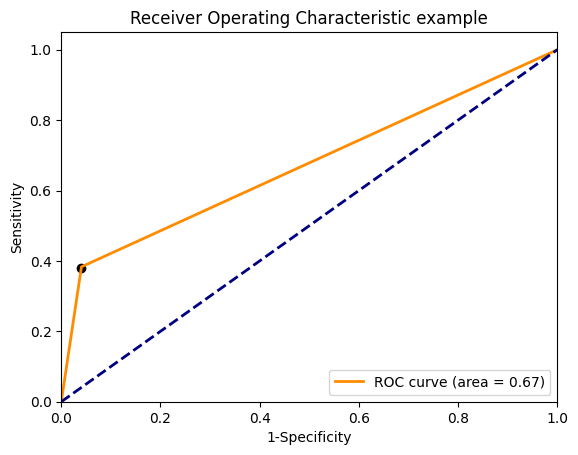

In [26]:
fpr, tpr, _ = roc_curve(y_test,mod.predict(x_test).apply(predict_group))
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter([0.04], [0.38],color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()

### Upsampling the train set to make the 0's and 1's evenly frequent

In [27]:
rand_sampler = RandomOverSampler(random_state=455)

x_train_upsampled, y_train_upsampled = rand_sampler.fit_resample(x_train,y_train)
print(f'x_train_upsampled: {x_train_upsampled.shape}')
print(f'y_train_upsampled: {y_train_upsampled.shape}')

x_train_upsampled: (308244, 22)
y_train_upsampled: (308244,)


In [28]:
y_train_upsampled.value_counts()

0    154122
1    154122
Name: gearbox, dtype: int64

### Second model - logistic regression with upsampled train set

In [29]:
model2 = sm.Logit(y_train_upsampled,x_train_upsampled).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.549728
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                gearbox   No. Observations:               308244
Model:                          Logit   Df Residuals:                   308222
Method:                           MLE   Df Model:                           21
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.2069
Time:                        18:39:52   Log-Likelihood:            -1.6945e+05
converged:                       True   LL-Null:                   -2.1366e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
price                   1.352e-08   1.29e-08      1.045      0.296   -1.18e-08    3.

### Classification report for the test set (based on model fit on the upsampled train set)

In [30]:
print(classification_report(y_pred=model2.predict(x_test).apply(predict_group),y_true=y_test))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     51055
           1       0.48      0.71      0.57     15948

    accuracy                           0.75     67003
   macro avg       0.69      0.74      0.70     67003
weighted avg       0.80      0.75      0.76     67003



## Random Forest

In [31]:
rf = RandomForestClassifier(max_features=5,n_estimators=200,random_state=424,max_depth=8)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=8, max_features=5, n_estimators=200,
                       random_state=424)

In [32]:
y_test_rf_pred = rf.predict(x_test)

### Classification report for the test set

In [33]:
print(classification_report(y_test,y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     51055
           1       0.78      0.43      0.56     15948

    accuracy                           0.84     67003
   macro avg       0.81      0.70      0.73     67003
weighted avg       0.83      0.84      0.82     67003



In [34]:
rf2 = RandomForestClassifier(max_features=5,n_estimators=200,random_state=234,max_depth=8)
rf2.fit(x_train_upsampled,y_train_upsampled)

RandomForestClassifier(max_depth=8, max_features=5, n_estimators=200,
                       random_state=234)

In [35]:
y_test_rf_pred2 = rf2.predict(x_test)

### Classification report for the test set (model fitted on upsampled train set)

In [36]:
print(classification_report(y_test,y_test_rf_pred2))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     51055
           1       0.54      0.72      0.62     15948

    accuracy                           0.79     67003
   macro avg       0.72      0.76      0.73     67003
weighted avg       0.82      0.79      0.80     67003



### Feature importance for the test set (model fitted on upsampled train set)

In [37]:
importances = rf2.feature_importances_

In [38]:
cols_list = x_train.columns.to_list()

In [39]:
importances_list = list(importances)

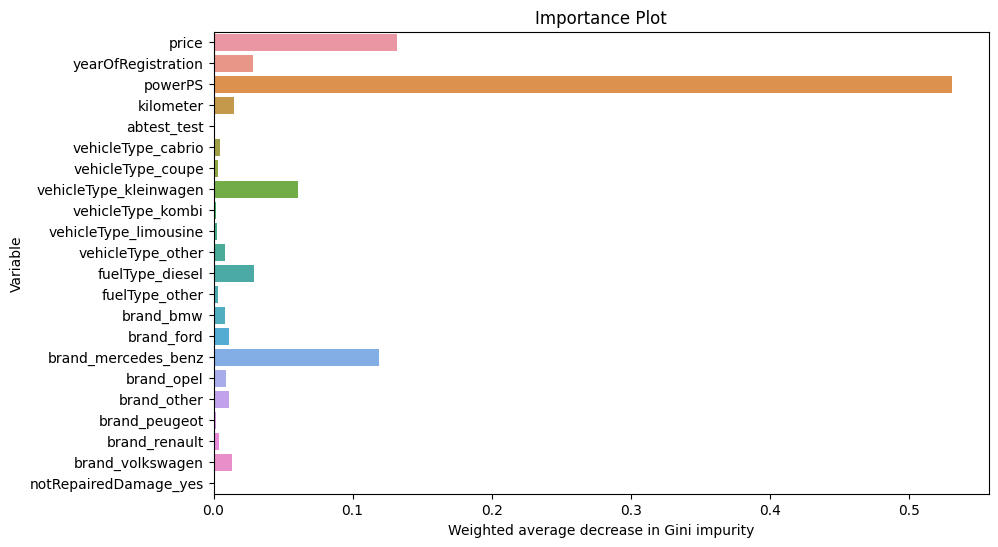

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(y=cols_list,x=importances_list)
plt.title('Importance Plot')
plt.ylabel('Variable')
plt.xlabel('Weighted average decrease in Gini impurity')
plt.show()

In [41]:
model_metrics_test_set = pd.DataFrame({'model_type':['logistic regression',
                                                    'logistic regression with upsampling',
                                                    'random forest',
                                                    'random forest with upsampling'],
                                        'train_or_test':['test','test','test','test'],
                                        'accuracy_score':[0.82,0.75,0.83,0.79],
                                        'recall: 0':[0.96,0.76,0.96,0.81],
                                        'recall: 1':[0.38,0.71,0.43,0.72],
                                        'precision 0':[0.83,0.89,0.84,0.90],
                                        'precision 1':[0.75,0.48,0.78,0.54]})

In [42]:
model_metrics_test_set

,model_type,train_or_test,accuracy_score,recall: 0,recall: 1,precision 0,precision 1
0,logistic regression,test,0.82,0.96,0.38,0.83,0.75
1,logistic regression with upsampling,test,0.75,0.76,0.71,0.89,0.48
2,random forest,test,0.83,0.96,0.43,0.84,0.78
3,random forest with upsampling,test,0.79,0.81,0.72,0.90,0.54


#### Random forest model (fitted on the upsampled train set) is probably the most suitable model, because its sensitivity and specificity is balanced. In reality it's better to have a little lower accuracy score but maintain balanced specificity and sensitivity